![Crack](https://media.giphy.com/media/YOkBRpVTeQsgobqLzC/giphy.gif)

# Introduction to Data Parallelism 🌆🌆

## What you will learn in this course 🧐🧐

This part is very exciting as we are going to train deep learning models in parallel and take advantage of more computing power!

<blockquote>
    
*  What is data parallelism ?

*  Train a deep learning model with 2 GPUs
</blockquote>


## What is distributed training? 💻💻

Have you ever wondered how machine learning models with millions to billions of parameters are trained on massive amounts of data? In reality, these models can be so large that they may not fit in the memory of a single processor, making conventional training impossible. Distributed training is one solution to this problem. Let's explore what it is and how it helps overcome these challenges. 

When faced with a huge task, we often divide it into smaller subtasks and run them in parallel to save time and make the process feasible. This is also true for deep learning, which is why we use distributed training. 

In distributed training, we split the training workload of a large deep learning model across multiple processors, also known as worker nodes or simply workers. These workers are trained in parallel to speed up the training process. There are two primary approaches to parallelism: data parallelism and model parallelism.
In this class we will focus primarly on **Data Parallelism**.

## Data parallelism ⚙️⚙️ 

This approach can be explain in 3 steps: 


1. We split the data into $n$ number of partitions, where $n$ is the total number of available workers in the compute cluster.

2. We copy the model in each worker node and each one of them performs the training on its own subset of the data.

3. We synchronize the model parameters, or gradients, at the end of the batch computation.



<img src="https://frankdenneman.nl/wp-content/uploads/2020/02/Data-Parallelism.png" width="850" height="380">



### Synchronous training 

Data parallelism involves dividing the data into partitions and distributing each part to a worker. Each worker trains on a portion of the data using a full replica of the model.


1.  During synchronous training, all workers perform the forward pass simultaneously, producing different outputs and gradients. The workers then wait for the other workers to complete their training loops and calculate gradients.

2.  Next, the workers communicate with each other and use the all-reduce algorithm to aggregate the gradients. Now after all the workers have completed computing gradients, all of them start communicating with each other and aggregate the gradients using the all-reduce algorithm, which we will discuss ahead. 

3.  Once the gradients are combined, the updated gradients are sent to all workers. Each worker can then perform the backward pass and update the local copy of the weights.

4.  The next forward pass does not begin until all workers have updated their weights, making this approach synchronous.

It is important to note that each worker produces different gradients because they train on different subsets of the data. However, at any given time, all workers have the same weights.




### All-reduce algorithm


The all-reduce algorithm is used to enable workers to share the load of storing and maintaining global parameters. With this algorithm, each worker shares its gradients with all other workers and applies a reduction operation to the target arrays. This reduces the target arrays in all workers to a single array, which is then returned to all workers.

There are several different implementations of the all-reduce algorithm, which dictate how these parameters are calculated and shared. 


1.  One such implementation involves all workers sending their gradients to a single "driver" worker, responsible for reducing the gradients and sending the updated gradients back to all workers. However, this approach can become a bottleneck as the number of processes increases, limiting its scalability.

2.  A less naive approach is the ring-all reduce algorithm, in which workers are organized in a ring, with each worker responsible for a specific subset of parameters shared only with the next worker in the ring. This approach dramatically reduces synchronization overhead and is a valuable tool for scaling machine learning models.



<img src="https://tech.preferred.jp/wp-content/uploads/2018/07/fig_3.png" width="650" height="280">


### Parameter server


Distributed training involves a cluster of workers, typically performing a singular task of training. However, it's possible to designate unique roles to each worker. For instance, some can act as parameter servers while others train the model.

The parameter servers hold and update the global state of the model's parameters, while the training workers execute the training loop, producing gradients and loss from the assigned data.

The training process can be summarized as follows: 


*  the model is replicated in all workers, and each worker uses a subset of data to train. 
*  Each training worker fetches the parameters from the parameter servers, 
*  Each training worker performs a training loop, and returns the gradients to all the parameter servers for updating the model's parameters.

Although this method allows independent training, it has a drawback. 


1.  At any given time, only one worker uses the latest version of the model, while the others rely on the outdated version. 

2.  Additionally, using a single worker as a parameter server can cause bottlenecks or a single point of failure in large clusters. However, this bottleneck issue can be mitigated to some degree by introducing multiple parallel servers.

## Get started 🏎️ 💨
 
How to use Multiple GPUs for training and inference of your TensorFlow/Keras model on Kaggle?

TensorFlow has a specific API to use Multiple GPUs for training and inference: `tf.distribute.Strategy` 

<img src="https://1.bp.blogspot.com/-yk08j0aKXxA/X9P3JlhLycI/AAAAAAAAD20/BzIfkCwNm_4jQ_U7oDe1p2boDPogqKUEgCLcBGAsYHQ/s0/image%2B1.png" width="450" height="250">


It allows you to do distributed training using existing models and training code with minimal changes.

We will use the `tf.distribute.MirroredStrategy` to perform in-graph replication with _synchronous training on 2 GPUs on this notebook. The strategy essentially copies all of the model's variables to each processor. Then, it uses `all reduce` to combine the gradients from all processors, and applies the combined value to all copies of the model.

We will use the `tf.keras` APIs to build the model and `Model.fit` for training it.


### GPUs Specifications

Before executing the rest of the notebook, let's make sure you have access to two T4.

You can do that by clicking on the option on the top right corner (vertical three dots) and go on te Accelerator options and verify it

or you can execute the command below:

In [45]:
!nvidia-smi

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Apr  8 09:50:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              48W /  70W |  14637MiB / 15360MiB |      0%      Default |
|                                         |                 

Now that you know you have the proper hardware for testing, lets see how to train a model in Keras with both GPUs

## MNIST


In this tutorial you will use the **MNIST** dataset but you can use any dataset you prefer.

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time

## Data Loading
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

print(X_train.shape)
print(y_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

## conveting the images to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

## converting the range to [0,1]
X_train /= 255
X_test /= 255

(60000, 28, 28)
(60000,)


In [20]:
print(X_train.shape)
print(y_train.shape)


(60000, 28, 28, 1)
(60000,)


Let's take a quick look at the data you've just loaded

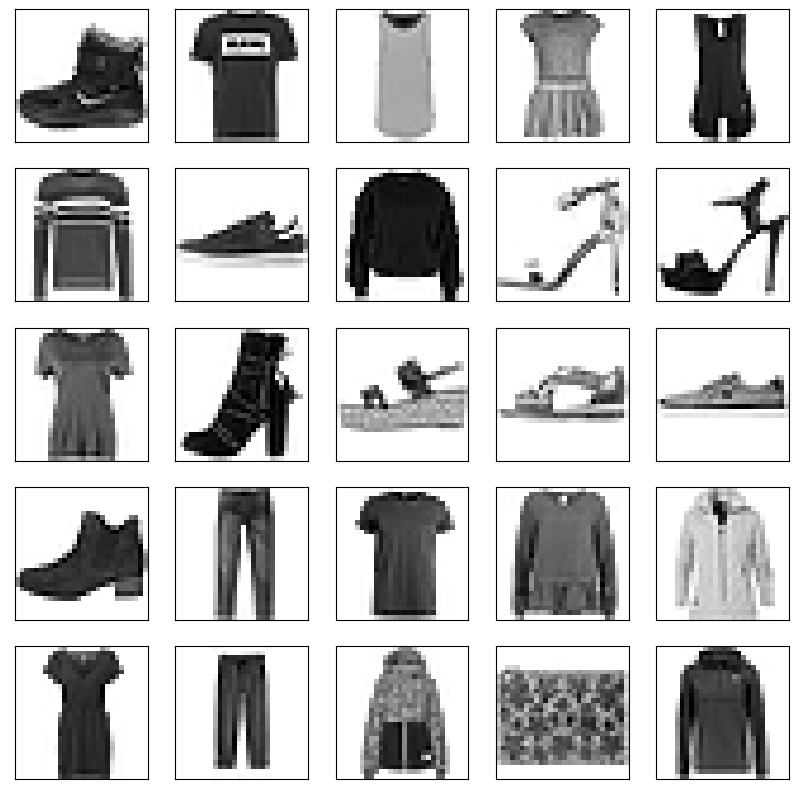

In [21]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

To make things better, lets put the data on a TF.dataset. With that you can control better batch size, caching and shuffling.

One important detail here is the BATCH_SIZE. To get the benefits of multiple GPUs, you have to optimize their use, otherwise you won't see the gains.

In [97]:
BUFFER_SIZE = 10000
BATCH_SIZE_PER_REPLICA = 1024

def get_batch_size(num_gpus=1):
    batch_size = BATCH_SIZE_PER_REPLICA * num_gpus
    print(f'BATCH_SIZE = {batch_size}')
    return batch_size

# Wrap data in Dataset objects.
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# the batch size will be defined later based on the number of used GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options).cache().shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.with_options(options)

## Defining a Distribution Strategy

To use Multi GPU (or multi machine, multi TPU) you will use the `tf.distribute.Strategy` API, 
more specifically `tf.distribute.MirroredStrategy`

This strategy will do the spliting of the work between both T4s for you

***Note***: You will need the context manager created here below when building the dataset and your model

In [98]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


## Building the model

This is the critical part!

The model has to be created inside a Strategy scope. The scope will make sure to place the model's variables on each processor. Then, it uses all-reduce to combine the gradients from all processors, and applies the combined value to all copies of the model.

To make sure you see the benefit of training in multiple GPUs, you always need to:

- use large enough batch size (you want to make sure you saturate the memory of the GPU)

otherwise, the cost of communicating between GPUs will eat up the gains of training the model.



In [99]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, [3, 3], activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        # tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(128, [3, 3], activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
    
    return model

In [100]:
# buiding a model inside the strategy scope
with strategy.scope():
    multi_gpu_model = build_model()
    
multi_gpu_model.summary()

# buiding a regular model on 1 GPU for performance comparison
regular_model = build_model()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_14 (Flatten)        (None, 1152)            

## Warmup

You still didn't use the GPUs yet!! The first time you access them, the framework will load aditional libraries not yet in memory and this would impact the timing of training the model.

On a regular situation, that doesn't affect much, it would just make the first epoch of training be slower but since you'll compare timing results later, it's better to warmup the GPUs by just running a predict on some data. The result doesn't matter but it will load all necessary libraries to memory.

In [101]:
EPOCHS = 1

d_train_data = train_data.batch(get_batch_size(strategy.num_replicas_in_sync))
history = multi_gpu_model.fit(d_train_data, epochs=EPOCHS)

BATCH_SIZE = 2048


/opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 3s 29ms/step - loss: 1.3334 - accuracy: 0.5707


## Training on 2 GPUs

In [102]:
EPOCHS = 60

d_train_data = train_data.batch(get_batch_size(strategy.num_replicas_in_sync))

start_time_multi = time.time()
history_multi = multi_gpu_model.fit(d_train_data, epochs=EPOCHS)
final_time_multi = time.time() - start_time_multi
print("--- %s seconds ---" % (final_time_multi))

BATCH_SIZE = 2048
Epoch 1/60
30/30 [==============================] - 1s 28ms/step - loss: 0.6725 - accuracy: 0.7505
Epoch 2/60
30/30 [==============================] - 1s 25ms/step - loss: 0.5516 - accuracy: 0.7955
Epoch 3/60
30/30 [==============================] - 1s 26ms/step - loss: 0.4849 - accuracy: 0.8236
Epoch 4/60
30/30 [==============================] - 1s 26ms/step - loss: 0.4381 - accuracy: 0.8430
Epoch 5/60
30/30 [==============================] - 1s 27ms/step - loss: 0.4036 - accuracy: 0.8578
Epoch 6/60
30/30 [==============================] - 1s 25ms/step - loss: 0.3837 - accuracy: 0.8628
Epoch 7/60
30/30 [==============================] - 1s 27ms/step - loss: 0.3608 - accuracy: 0.8709
Epoch 8/60
30/30 [==============================] - 1s 26ms/step - loss: 0.3503 - accuracy: 0.8742
Epoch 9/60
30/30 [==============================] - 1s 26ms/step - loss: 0.3423 - accuracy: 0.8756
Epoch 10/60
30/30 [==============================] - 1s 26ms/step - loss: 0.3268 - accuracy

Just for a simple comparison, you'll create a model without the the distribution strategy

The dataset will also have a proportional batch size since it's doing all the work alone

aside from the first epoch which may be faster, all the other ones will be slower than with multiple GPUs

## Training on 1 GPU

In [103]:
regular_train_data = train_data.batch(get_batch_size())

start_time_single = time.time()
history_regular = regular_model.fit(regular_train_data, epochs=EPOCHS)
final_time_single = time.time() - start_time_single
print("--- %s seconds ---" % (final_time_single))

BATCH_SIZE = 1024
Epoch 1/60
59/59 [==============================] - 2s 22ms/step - loss: 1.0235 - accuracy: 0.6430
Epoch 2/60
59/59 [==============================] - 1s 22ms/step - loss: 0.5739 - accuracy: 0.7824
Epoch 3/60
59/59 [==============================] - 1s 22ms/step - loss: 0.4730 - accuracy: 0.8257
Epoch 4/60
59/59 [==============================] - 1s 22ms/step - loss: 0.4210 - accuracy: 0.8470
Epoch 5/60
59/59 [==============================] - 1s 22ms/step - loss: 0.3769 - accuracy: 0.8660
Epoch 6/60
59/59 [==============================] - 1s 22ms/step - loss: 0.3512 - accuracy: 0.8742
Epoch 7/60
59/59 [==============================] - 1s 22ms/step - loss: 0.3270 - accuracy: 0.8830
Epoch 8/60
59/59 [==============================] - 1s 22ms/step - loss: 0.3105 - accuracy: 0.8880
Epoch 9/60
59/59 [==============================] - 1s 22ms/step - loss: 0.3027 - accuracy: 0.8892
Epoch 10/60
59/59 [==============================] - 1s 22ms/step - loss: 0.2892 - accuracy

## Performance Comparison

### Accuracy Comparison

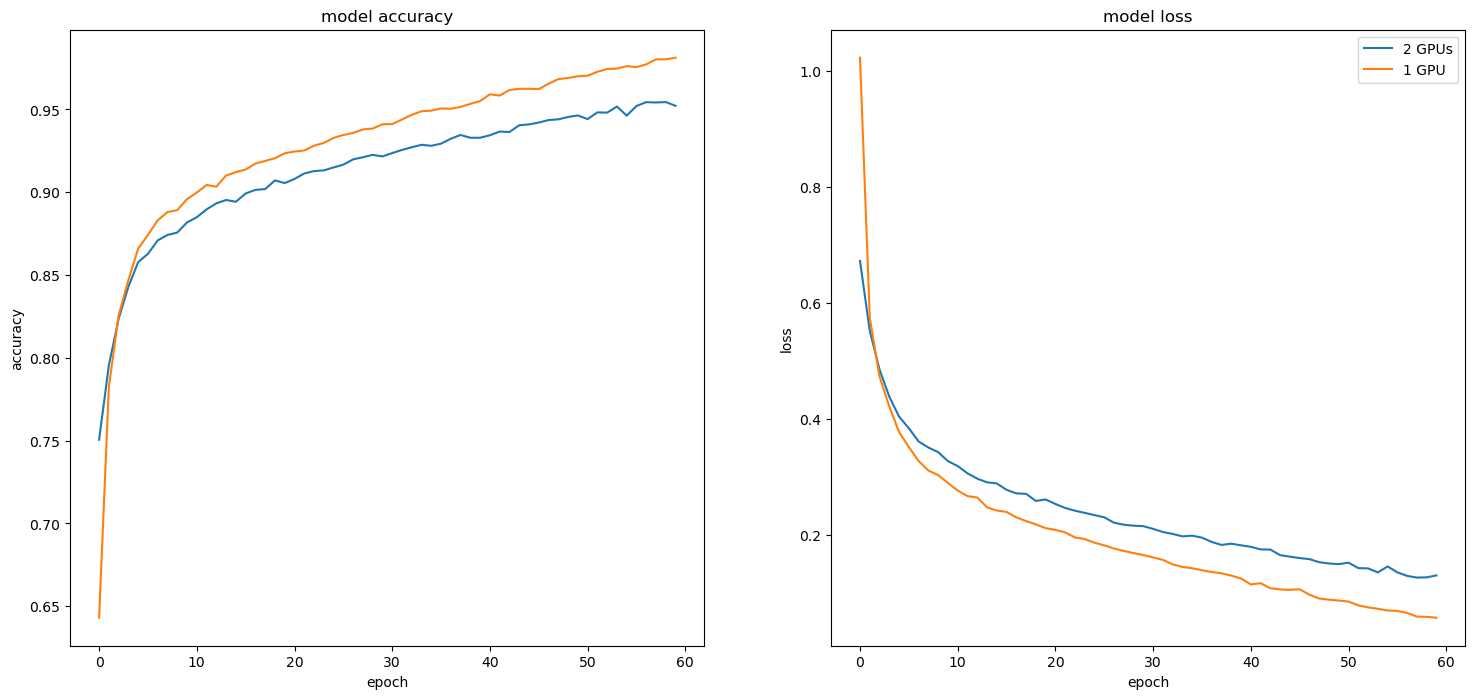

In [104]:
fig, axs = plt.subplots(1, 2,figsize=(18,8))
axs[0].plot(history_multi.history['accuracy'],label = '2 GPUs')
axs[0].plot(history_regular.history['accuracy'],label = '1 GPU')
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')


axs[1].plot(history_multi.history['loss'],label = '2 GPUs')
axs[1].plot(history_regular.history['loss'],label = '1 GPU')
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')

plt.legend()
plt.show()

### Computing Power Comparison

We achieve 18.09 percent of scaling


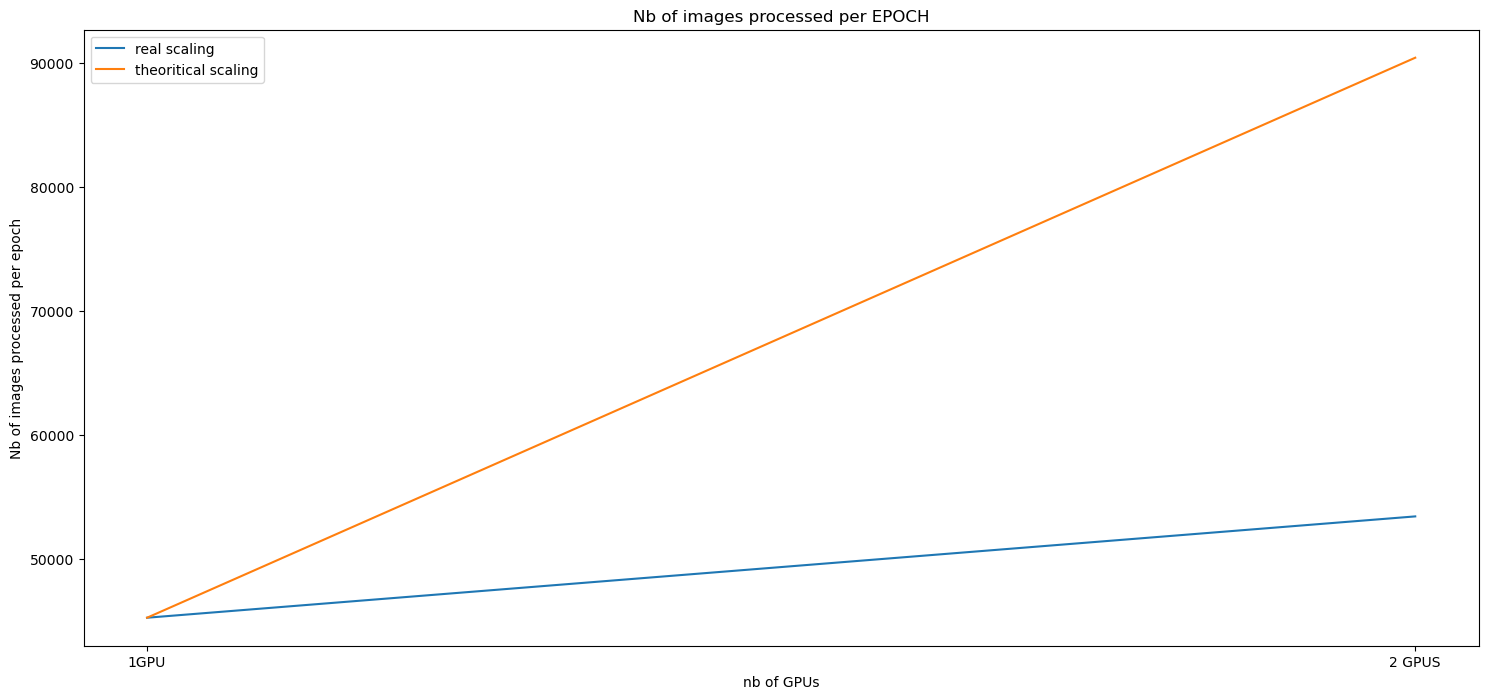

In [105]:
plt.figure(figsize=(18,8))
nb_images = len(train_data)
plt.plot(['1GPU','2 GPUS'],[nb_images/(final_time_single/EPOCHS),nb_images/(final_time_multi/EPOCHS)],label = 'real scaling')
plt.plot(['1GPU','2 GPUS'],[nb_images/(final_time_single/EPOCHS),2*nb_images/(final_time_single/EPOCHS)],label = 'theoritical scaling')
plt.title('Nb of images processed per EPOCH')
plt.ylabel('Nb of images processed per epoch')
plt.xlabel('nb of GPUs')
plt.legend()
print("We achieve %s percent of scaling"% round((final_time_single/final_time_multi - 1)*100,2))

When going from training with a single GPU to multiple GPUs on the same host, ideally you should experience the performance scaling with only the additional overhead of gradient communication and increased host thread utilization. Because of this overhead, you will not have an exact 2x speedup if you move from 1 to 2 GPUs, for example.

## Let's sum it up 🔚🔚

Using multiple GPU with TensorFlow is as easy as creating a distribution strategy.
There's no need to make any big changes to your model or to the data.

Kaggle Notebooks only has 2 x t4 gpus availbable, you'll be able to train bigger models faster and experiment more with some cloud providers like AWS Sagemaker, GCP etc...

## Extra Resources

There are a lot of tutorials on how to optimize execution when you have access to multiple GPU:

- [Horovod](https://github.com/horovod/horovod)
- [Distributed training with Keras](https://www.tensorflow.org/tutorials/distribute/keras)
- [Optimize the performance on the multi-GPU single host](https://www.tensorflow.org/guide/gpu_performance_analysis#2_optimize_the_performance_on_the_multi-gpu_single_host)
- [Solve GLUE tasks using BERT on TPU](https://www.tensorflow.org/text/tutorials/bert_glue) tutorial uses `tf.distribute.MirroredStrategy` for training on GPUs and `tf.distribute.TPUStrategy` on TPUs. This tutorial is great to understand how to solve NLP problems.
- [Save and load a model using a distribution strategy](https://www.tensorflow.org/tutorials/distribute/save_and_load) tutorial demonstates how to use the SavedModel APIs with `tf.distribute.Strategy`.
